In [1]:
import os
import sys
import yaml
import math
import itertools

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# What this is for
I was noticing some weird results in the PVI baselines I was runnning. Wanted to check them out. Ran a quick sweep of a distributed number of clients to see what was going on.

In [2]:
with open('../experiment_configs/PVI_baseline.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

experiment_config

{'dataset.name': ['adult', 'abalone'],
 'dataset_dist.M': [1, 10, 20, 30, 50, 100]}

In [3]:
all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

In [4]:
dp_configs

[{'dataset.name': 'adult', 'dataset_dist.M': 1},
 {'dataset.name': 'adult', 'dataset_dist.M': 10},
 {'dataset.name': 'adult', 'dataset_dist.M': 20},
 {'dataset.name': 'adult', 'dataset_dist.M': 30},
 {'dataset.name': 'adult', 'dataset_dist.M': 50},
 {'dataset.name': 'adult', 'dataset_dist.M': 100},
 {'dataset.name': 'abalone', 'dataset_dist.M': 1},
 {'dataset.name': 'abalone', 'dataset_dist.M': 10},
 {'dataset.name': 'abalone', 'dataset_dist.M': 20},
 {'dataset.name': 'abalone', 'dataset_dist.M': 30},
 {'dataset.name': 'abalone', 'dataset_dist.M': 50},
 {'dataset.name': 'abalone', 'dataset_dist.M': 100}]

In [5]:
adult_configs = [d for d in dp_configs if d['dataset.name'] == 'adult']
abalone_configs = [d for d in dp_configs if d['dataset.name'] == 'abalone']

In [6]:
results_access = SacredExperimentAccess(database_name='test_comparison')

In [7]:
adult_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in adult_configs]
abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

In [8]:
adult_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_experiments]
abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

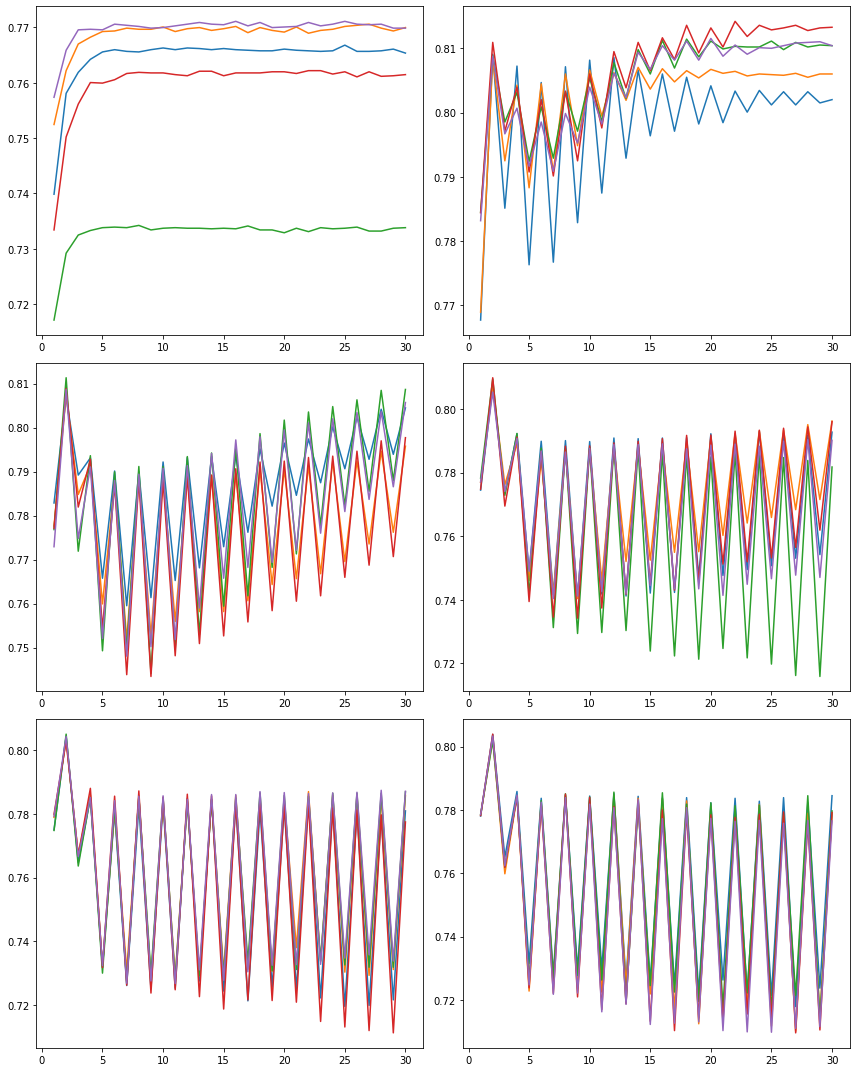

In [9]:
plt.figure(figsize=(12, 15))
cols = math.floor(math.sqrt(len(adult_configs)))
rows = math.ceil(len(adult_configs) / cols)
for i, (config, experiments, metrics) in enumerate(zip(adult_configs, adult_experiments, adult_metrics)):
    plt.subplot(rows, cols, i+1)
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    plt.plot(steps, values)
    
plt.tight_layout()

Clearly we need some damping on this. Not sure how much, but it seems to get worse with more clients. Will try a further set of experiments to grid over the possibilities for damping factor and number of clients. Potentially might be a $1/M$ relationship to look for. Next notebook will be called `PVI_damping_investigation`. Note erratic behaviour looks consistent over seeds, will only run one of each.